
Model Performance:
Mean Absolute Error: 21.02%
R-squared: -0.28
Cross-validated R-squared: -33.34

Feature Importances:
           Feature  Importance
1             Year    0.518155
2   Region_Encoded    0.270382
0  Country_Encoded    0.191713
3           Decade    0.019750


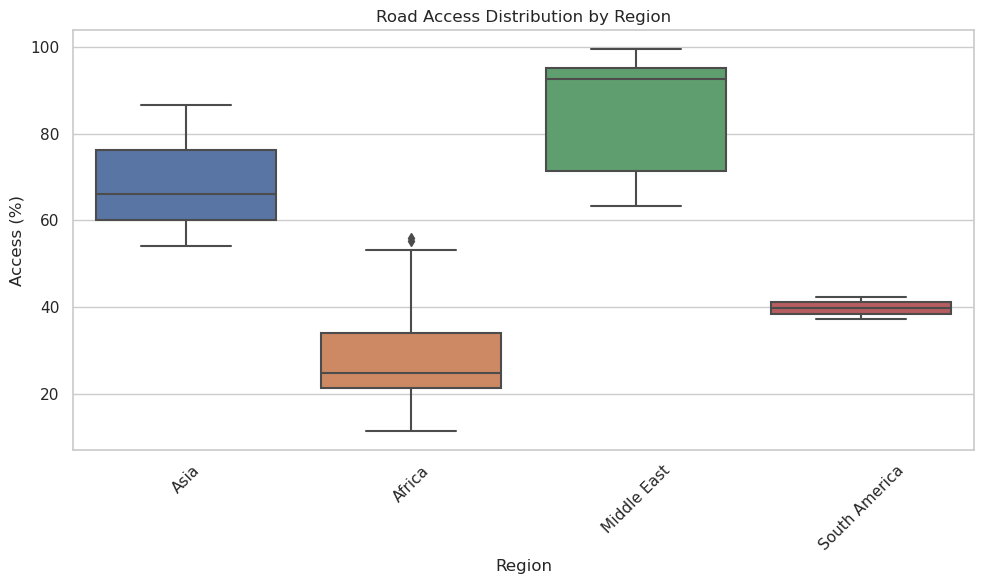

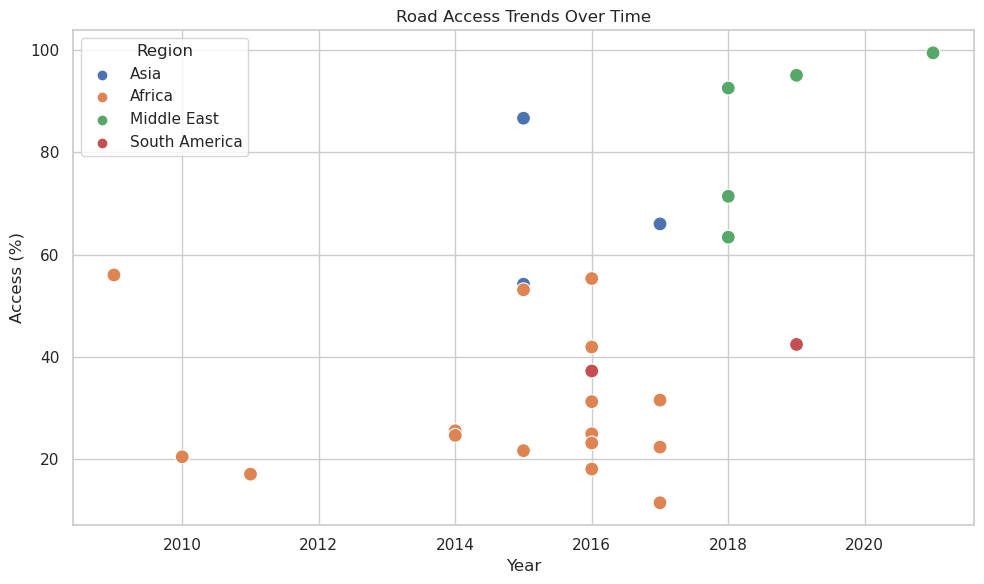

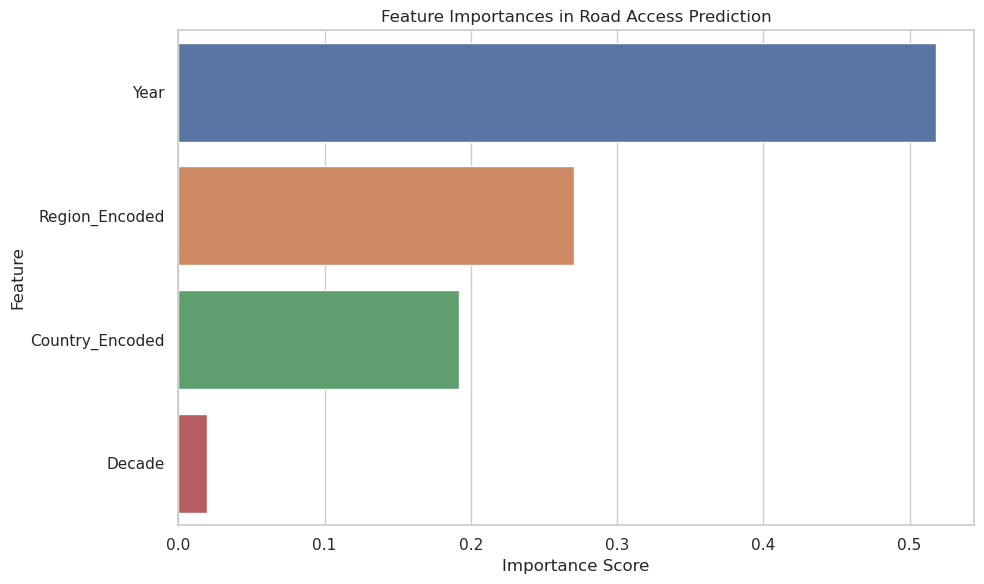


Ethical Considerations:
1. Data Limitations: Dataset covers only 26 entries from 24 countries
2. Geographical Bias: Africa is over-represented (15/26 entries)
3. Temporal Gaps: Data spans 2009-2021 with inconsistent year coverage
4. Implementation: Model should be regularly updated with new data
5. Equity Focus: Special attention needed for low-access regions (Africa avg: 28.5%)

Predicted road access for Ethiopia in 2023: 52.2%

Model deployment preparation:
1. Save model using joblib for production use
2. Create API endpoint for predictions
3. Build dashboard for monitoring and visualization
4. Implement data pipeline for regular updates


In [6]:



# ------ 1. SETUP AND DATA EXTRACTION ------
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data 
data = [
    # Format: [Country, Year, Access (%)]
    ['Bangladesh', 2015, 86.7],
    ['Armenia', 2017, 66],
    ['Burundi', 2016, 24.9],
    ['Ethiopia', 2015, 21.6],
    ['Iraq', 2018, 63.4],
    ['Jordan', 2018, 71.4],
    ['Kenya', 2009, 56],
    ['Lebanon', 2018, 92.6],
    ['Lesotho', 2016, 18],
    ['Liberia', 2016, 41.9],
    ['Madagascar', 2017, 11.4],
    ['Malawi', 2016, 23.1],
    ['Mali', 2017, 22.3],
    ['Mozambique', 2010, 20.4],
    ['Nepal', 2015, 54.2],
    ['Nigeria', 2014, 25.5],
    ['Paraguay', 2019, 42.4],
    ['Peru', 2016, 37.2],
    ['Rwanda', 2016, 55.3],
    ['Sierra Leone', 2017, 31.5],
    ['Somalia', 2016, 31.2],
    ['United Arab Emirates', 2019, 95.1],
    ['United Arab Emirates', 2021, 99.5],
    ['Uganda', 2015, 53.1],
    ['Tanzania', 2014, 24.6],
    ['Zambia', 2011, 17]
]

# Create DataFrame
df = pd.DataFrame(data, columns=['Country', 'Year', 'Access_Percentage'])

# ------ 2. FEATURE ENGINEERING ------
# Add region feature
country_to_region = {
    'Bangladesh': 'Asia', 'Armenia': 'Asia', 'Burundi': 'Africa', 
    'Ethiopia': 'Africa', 'Iraq': 'Middle East', 'Jordan': 'Middle East',
    'Kenya': 'Africa', 'Lebanon': 'Middle East', 'Lesotho': 'Africa',
    'Liberia': 'Africa', 'Madagascar': 'Africa', 'Malawi': 'Africa',
    'Mali': 'Africa', 'Mozambique': 'Africa', 'Nepal': 'Asia',
    'Nigeria': 'Africa', 'Paraguay': 'South America', 'Peru': 'South America',
    'Rwanda': 'Africa', 'Sierra Leone': 'Africa', 'Somalia': 'Africa',
    'United Arab Emirates': 'Middle East', 'Uganda': 'Africa',
    'Tanzania': 'Africa', 'Zambia': 'Africa'
}

df['Region'] = df['Country'].map(country_to_region)

# Add decade feature
df['Decade'] = (df['Year'] // 10) * 10

# Add access category
df['Access_Category'] = pd.cut(df['Access_Percentage'],
                               bins=[0, 30, 60, 100],
                               labels=['Low', 'Medium', 'High'])

# ------ 3. DATA PREPROCESSING ------
# Encode categorical features
le_country = LabelEncoder()
le_region = LabelEncoder()
le_access = LabelEncoder()

df['Country_Encoded'] = le_country.fit_transform(df['Country'])
df['Region_Encoded'] = le_region.fit_transform(df['Region'])
df['Access_Category_Encoded'] = le_access.fit_transform(df['Access_Category'])

# Prepare features and target
X = df[['Country_Encoded', 'Year', 'Region_Encoded', 'Decade']]
y = df['Access_Percentage']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------ 4. MODEL BUILDING (RANDOM FOREST) ------
# Initialize and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# ------ 5. MODEL EVALUATION ------
# Predictions
y_pred = model.predict(X_test_scaled)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Mean Absolute Error: {mae:.2f}%")
print(f"R-squared: {r2:.2f}")

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {np.mean(cv_scores):.2f}")

# ------ 6. FEATURE IMPORTANCE ANALYSIS ------
# Get feature importances
importances = model.feature_importances_
features = X.columns

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)

# ------ 7. VISUALIZATION ------
# Set style
sns.set(style="whitegrid")

# Plot 1: Access by region
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Access_Percentage', data=df)
plt.title('Road Access Distribution by Region')
plt.xticks(rotation=45)
plt.ylabel('Access (%)')
plt.tight_layout()
plt.savefig('access_by_region.png', dpi=300)
plt.show()

# Plot 2: Access trends over time
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Access_Percentage', hue='Region', data=df, s=100)
plt.title('Road Access Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Access (%)')
plt.legend(title='Region')
plt.tight_layout()
plt.savefig('access_trends.png', dpi=300)
plt.show()

# Plot 3: Feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances in Road Access Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

# ------ 8. ETHICAL CONSIDERATIONS ------
print("\nEthical Considerations:")
print("1. Data Limitations: Dataset covers only 26 entries from 24 countries")
print("2. Geographical Bias: Africa is over-represented (15/26 entries)")
print("3. Temporal Gaps: Data spans 2009-2021 with inconsistent year coverage")
print("4. Implementation: Model should be regularly updated with new data")
print("5. Equity Focus: Special attention needed for low-access regions (Africa avg: 28.5%)")

# ------ 9. SAMPLE PREDICTION ------
# Predict for Ethiopia in 2023
ethiopia_code = le_country.transform(['Ethiopia'])[0]
region_code = le_region.transform(['Africa'])[0]
sample = pd.DataFrame({
    'Country_Encoded': [ethiopia_code],
    'Year': [2023],
    'Region_Encoded': [region_code],
    'Decade': [2020]
})

sample_scaled = scaler.transform(sample)
predicted_access = model.predict(sample_scaled)[0]

print(f"\nPredicted road access for Ethiopia in 2023: {predicted_access:.1f}%")

# ------ 10. MODEL DEPLOYMENT PREPARATION ------
# Save model components (in a real scenario)
print("\nModel deployment preparation:")
print("1. Save model using joblib for production use")
print("2. Create API endpoint for predictions")
print("3. Build dashboard for monitoring and visualization")
print("4. Implement data pipeline for regular updates")






